# **Mount Google Drive for Reading in Data**

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# **PIP Required Dependencies**

In [2]:
pip install svgling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 3.7 MB/s eta 0:00:00


In [3]:
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from tabulate import tabulate
import pprint
import re
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
nltk.download('wordnet')
import math
from sklearn.metrics import accuracy_score

plt.style.use('ggplot')

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
# splitting the data set into training set and test set
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Set Paths for Reading datasets from Google Drive**

In [4]:

barcelonaPath = '/content/drive/MyDrive/Barcelona_reviews.csv'
londonPath = '/content/drive/MyDrive/London_reviews.csv'
madridPath = '/content/drive/MyDrive/Madrid_reviews.csv'
nyPath = '/content/drive/MyDrive/New_York_reviews.csv'
parisPath = '/content/drive/MyDrive/Paris_reviews.csv'
ndelhiPath = '/content/drive/MyDrive/New_Delhi_reviews.csv'

# **Create Custom Function To Format/Clean Data**

In [5]:
def CleanUprDataFromPath(path, cityName):
  print("Generating Clean Working Dataframe from path: ", path)
  #Read in the data from gdrive
  df = pd.read_csv(path, on_bad_lines='skip')
  #rename 'sample' column to 'sentiment'
  df = df.rename(columns={"sample": "sentiment"})

  #trim down columns (down sample)
  df = df[['sentiment','review_full',]]
 

  df = df.head(2500)
  print(df.shape[0])
  
  #make the index column the first column
  #first_column = df.pop("index_column")
  #df.insert(0,'index_column', first_column)

  print("\nChecked for NA's Count is:\n", df.isna().sum(), end="\n")
  print("\n", df.head().to_markdown())

  return df    



# **Run Cleaning and Formatting Function on Desired Datasets**

In [6]:
barce_df = CleanUprDataFromPath(barcelonaPath, "Barcelona")
madrid_df = CleanUprDataFromPath(madridPath, "Mardrid")
ny_df = CleanUprDataFromPath(nyPath, "New York City")

Generating Clean Working Dataframe from path:  /content/drive/MyDrive/Barcelona_reviews.csv


<ipython-input-5-88704c1a1fe9>:4: DtypeWarning: Columns (0,1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, on_bad_lines='skip')


2500

Checked for NA's Count is:
 sentiment      0
review_full    0
dtype: int64

 |    | sentiment   | review_full                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          |
|---:|:------------|:--------------------

<ipython-input-5-88704c1a1fe9>:4: DtypeWarning: Columns (0,1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, on_bad_lines='skip')


2500

Checked for NA's Count is:
 sentiment      0
review_full    0
dtype: int64

 |    | sentiment   | review_full                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |
|---:|:------------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [7]:
#Combine the Df's
addRev = pd.concat([barce_df, madrid_df, ny_df])
print(addRev.head())

  sentiment                                        review_full
0  Negative  Ok, this place is terrible! Came here bc we’ve...
1  Positive  This place was a great surprise. The food is d...
2  Positive  The food is excellent.....the ambiance is very...
3  Positive  The food is execellent ,affortable price for p...
4  Positive  Mr Suarez,The food at your restaurant was abso...


In [8]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    st = ""
    for w in w_tokenizer.tokenize(text):
        st = st + lemmatizer.lemmatize(w) + " "
    return st
  
addRev['review_full'] = addRev.review_full.apply(lemmatize_text)

In [9]:
reviews = addRev['review_full'].values
labels = addRev['sentiment']


In [10]:
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)
train_sentences, test_sentences, train_labels, test_labels = train_test_split(reviews, encoded_labels, stratify = encoded_labels)

In [11]:

# creating bag of words model
vec = CountVectorizer(max_features = 3000)
X = vec.fit_transform(train_sentences)
vocab = vec.get_feature_names_out()
X = X.toarray()
word_counts = {}
for l in range(2):
    word_counts[l] = defaultdict(lambda: 0)
for i in range(X.shape[0]):
    l = train_labels[i]
    for j in range(len(vocab)):
        word_counts[l][vocab[j]] += X[i][j]

In [12]:
def laplace_smoothing(n_label_items, vocab, word_counts, word, text_label):
    a = word_counts[text_label][word] + 1
    b = n_label_items[text_label] + len(vocab)
    return math.log(a/b)

In [13]:
def group_by_label(x, y, labels):
    data = {}
    for l in labels:
        data[l] = x[np.where(y == l)]
    return data

In [14]:
def fit(x, y, labels):
    n_label_items = {}
    log_label_priors = {}
    n = len(x)
    grouped_data = group_by_label(x, y, labels)
    for l, data in grouped_data.items():
        n_label_items[l] = len(data)
        log_label_priors[l] = math.log(n_label_items[l] / n)
    return n_label_items, log_label_priors

In [15]:
def predict(n_label_items, vocab, word_counts, log_label_priors, labels, x):
    result = []
    for text in x:
        label_scores = {l: log_label_priors[l] for l in labels}
        words = set(w_tokenizer.tokenize(text))
        for word in words:
            if word not in vocab: continue
            for l in labels:
                log_w_given_l = laplace_smoothing(n_label_items, vocab, word_counts, word, l)
                label_scores[l] += log_w_given_l
        result.append(max(label_scores, key=label_scores.get))
    return result

In [16]:
labels = [0,1]
n_label_items, log_label_priors = fit(train_sentences,train_labels,labels)
pred = predict(n_label_items, vocab, word_counts, log_label_priors, labels, test_sentences)
print("Accuracy of prediction on test set : ", accuracy_score(test_labels,pred))

Accuracy of prediction on test set :  0.9408


# NaiveBayes

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
)

In [18]:
addRev.head()

,sentiment,review_full
0,Negative,"Ok, this place is terrible! Came here bc we’ve..."
1,Positive,This place wa a great surprise. The food is de...
2,Positive,The food is excellent.....the ambiance is very...
3,Positive,"The food is execellent ,affortable price for p..."
4,Positive,"Mr Suarez,The food at your restaurant wa absol..."


In [19]:
addRev['sentiment'] = addRev['sentiment'].astype("category")
addRev['review_full'] = addRev['review_full'].astype(str)

addRev.dtypes

sentiment      category
review_full      object
dtype: object

In [20]:
train, test = train_test_split(addRev, test_size=0.2)

count_vec = CountVectorizer()
bowArr = count_vec.fit_transform(addRev['review_full'].tolist())
bow = np.array(bowArr.todense())

x = bow
labelss = addRev['sentiment']




In [21]:
labelss.cat.categories

Index(['Negative', 'Positive'], dtype='object')

In [22]:
X_train, X_test, y_train, y_test = train_test_split(x, labelss, 
                                                    test_size=0.2)

In [23]:
model = MultinomialNB().fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.952
              precision    recall  f1-score   support

    Negative       0.66      0.23      0.35        81
    Positive       0.96      0.99      0.98      1419

    accuracy                           0.95      1500
   macro avg       0.81      0.61      0.66      1500
weighted avg       0.94      0.95      0.94      1500



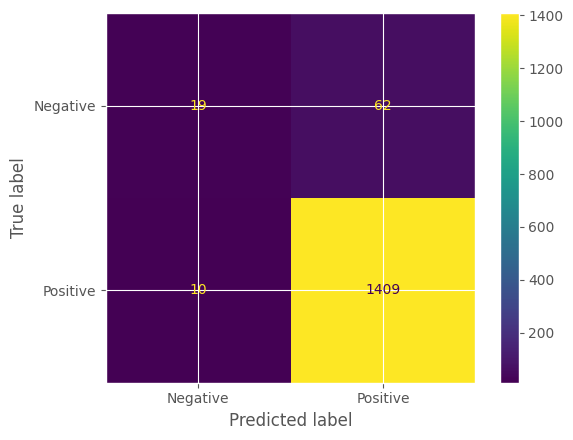

In [24]:
labels = ["Negative", "Positive"]
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot();

In [25]:
def print_top20(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names_out()
    for i, class_label in enumerate(class_labels):
        top20 = np.argsort(clf.feature_log_prob_[0])[20:]
        print("%s: %s" % (class_label,
              " ".join(feature_names[j] for j in top20)))

In [26]:
len(model.feature_log_prob_[0])
cols = count_vec.get_feature_names_out()
feaDf = pd.DataFrame(bowArr.toarray(), columns = cols)


In [27]:
type(cols)

numpy.ndarray

In [28]:
type(model.feature_log_prob_[0])

numpy.ndarray

In [29]:
feaDf = pd.DataFrame()



In [30]:
feaDf['word'] = cols
feaDf['coefficient'] = model.feature_log_prob_[0]
feaDf = feaDf.sort_values(by='coefficient', ascending=False)

In [33]:
feaDf.head(20
           )

,word,coefficient
12889,the,-3.125106
809,and,-3.692108
13923,wa,-3.943533
13065,to,-4.061814
14032,we,-4.236542
8736,of,-4.415930
6870,it,-4.432034
6592,in,-4.588080
5352,for,-4.667016
8625,not,-4.717554
